In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import astropy.io as ascii
from astropy.io import fits
from scipy.optimize import curve_fit
import os
import nkrpy
from importlib import reload
from nkrpy import atomiclines
from nkrpy import constants
from nkrpy.miscmath import *
atomiclines = reload(nkrpy.atomiclines)
llines = atomiclines.lines()
listoflines = atomiclines.call(wtype='nir',bu='microns').return_lines()

# Pretty Plotting

In [5]:
def plotting(ax,xmin,xmax,x,y,tempsource,line,count,start=False):
    colours = ['orange','black','blue','red',\
              'green','grey','purple']
    colour = colours[count%len(colours)]
    y = np.array(y)
    x = np.array(x)
    origx = x.copy()
    origy = y.copy()
    x = x[~np.isnan(origy)]
    y = y[~np.isnan(origy)]
     
    print("Count: {},Before: {},{}".format(count,x.shape,y.shape))
    if start == False:
        temp = []
        if count == 0:
            for i,j in enumerate(x):
                if (j < 1.7):
                    temp.append(i)
        elif count == 1:
            for i,j in enumerate(x):
                if ((1.75 < j) or (j < 1.5)):
                    temp.append(i)
        elif count == 2:
            for i,j in enumerate(x):
                if (1.33 < j) or (j < 1.17):
                    temp.append(i)
        elif count == 3:
            for i,j in enumerate(x):
                if ((j < 1.05) or ((1.11<j)) and (j<1.17)): 
                    temp.append(i)
        elif count == 4:
            for i,j in enumerate(x):
                if (j < 0.95):
                    temp.append(i)
        temp = np.array(temp)
        temp.sort()
        tempx = np.delete(x,temp)
        tempy = np.delete(y,temp)
        expected = [1.,1.]
        params,cov = curve_fit(linear,tempx,tempy,expected)
        #print(params)
        if len(temp) > 0:
            y[temp[0]] = linear(x[temp[0]],*params)
            y[temp[len(temp)-1]] = linear(x[temp[len(temp)-1]],*params)
            x = np.delete(x,temp[1:len(temp)-1])
            y = np.delete(y,temp[1:len(temp)-1])

        print("After: {},{}".format(x.shape,y.shape))
        if x.shape[0] == 0:
            x = origx
            y = origy
        count +=1
    ax.plot(x,y,'-',color=colour,label=tempsource[-6:])
    for f in line:
        #print(f)
        if f == 'brg':
            naming = r'Br $\gamma$'
        elif f == 'pab':
            naming = r'Pa $\beta$'
        elif f == 'pag':
            naming = r'Pa $\gamma$'
        else:
            naming = f
        for pl,pj in enumerate(line[f]):
            #print(pl,pj)
            if (pl < (len(line[f]))):
                if pj > 100:
                    pj = pj/10000
                val = int(int(min(range(len(x)),key=lambda i:abs(x[i]-pj))))
                if (xmin <= pj <= xmax )and (min(x) <= pj <= max(x) ):
                    if 10<=val<len(x)-11:
                        region=y[val-10:val+10] 
                    elif val > 0:
                        region=y[val:val+10]
                    elif val<len(x)-1:
                        region=y[val-10:val]
                    else:
                        region = y[val]
                    try:
                        linepos = max(region)
                    except ValueError:
                        linepos = 5*np.nanmean(x)
                    ax.text(pj, linepos*1.05, naming,
                        verticalalignment='bottom',
                        horizontalalignment='center',
                        fontsize=10, color='red',rotation='vertical')

                    ax.plot((pj,pj),(linepos,linepos*1.05),'r-')

<IPython.core.display.Javascript object>


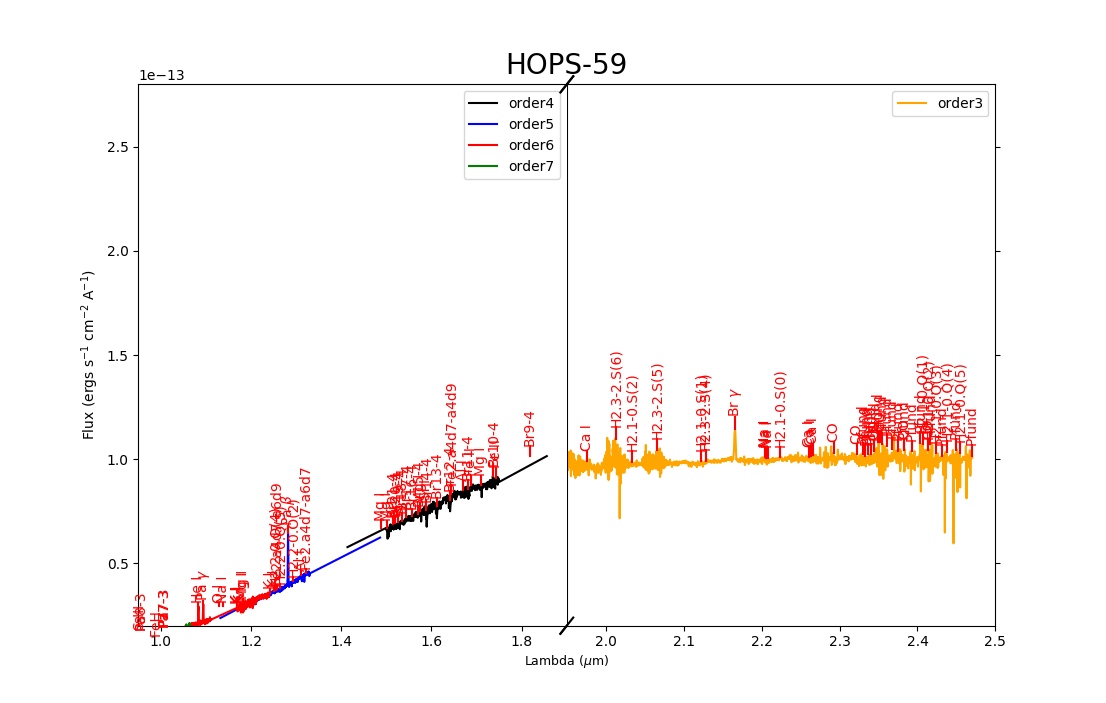

(5, 3, 2048)
Count: 0,Before: (2047,),(2047,)
After: (2047,),(2047,)


/net/ryle/myhome1/reynolds/programs/ryle-linuxbrew/opt/python/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/net/ryle/myhome1/reynolds/programs/ryle-linuxbrew/opt/python/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


Count: 1,Before: (2047,),(2047,)
After: (1158,),(1158,)
Count: 2,Before: (2047,),(2047,)
After: (921,),(921,)
Count: 3,Before: (2046,),(2046,)
After: (908,),(908,)
Count: 4,Before: (1246,),(1246,)
After: (930,),(930,)


In [6]:
%matplotlib notebook
source = 'HOPS-59'
if not os.path.isdir(source):
    os.mkdir(source)
listoffiles='HOPS-59.tellcor.fits'
# make sure you add statement for naming
f,(ax1,ax2) = plt.subplots(1,2,sharey=True,facecolor='w')
plt.text(1., 1.02, source,
         horizontalalignment='center',
         fontsize=20,
         transform = ax1.transAxes)
count = 0
start=False
orderlim=5
xmin1=0.95
xmax1=1.9
xmin2=1.95
xmax2=2.5
ymin = 0.2E-13
ymax = 2.8E-13
ax1.set_xlim(xmin1,xmax1)
ax2.set_xlim(xmin2,xmax2)
ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax1.tick_params(labelright='off')
ax2.yaxis.tick_right()
ax1.set_ylabel(r"Flux (ergs s$^{-1}$ cm$^{-2}$ A$^{-1}$)")
label = ax1.set_xlabel(r'Lambda ($\mu$m)', fontsize = 9)
ax1.xaxis.set_label_coords(1., -0.05)
plt.ylim(ymin,ymax)
hdulist = fits.open(listoffiles)
print(hdulist[0].data.shape)
for j in range(len(hdulist[0].data[:,0,:])):   
    if j != orderlim:
        lam = hdulist[0].data[j,0,:]
        flux = hdulist[0].data[j,1,:]
        eflux = hdulist[0].data[j,2,:]
        if j > 0:
            plotting(ax1,xmin1,xmax1,lam,flux,source+"_order"+str(j+3),listoflines,count,start)
        else:
            plotting(ax2,xmin2,xmax2,lam,flux,source+"_order"+str(j+3),listoflines,count,start)
    count +=1
            
d = .015 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1-d,1+d), (-d,+d), **kwargs)
ax1.plot((1-d,1+d),(1-d,1+d), **kwargs)

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d,+d), (1-d,1+d), **kwargs)
ax2.plot((-d,+d), (-d,+d), **kwargs)
ax2.plot((xmin2,xmin2),(-100,100),color='black')

plt.subplots_adjust(wspace=0, hspace=0)
ax1.legend()
ax2.legend()
plt.savefig(source+'/'+source+'_combined.pdf',dpi=1000)

<IPython.core.display.Javascript object>


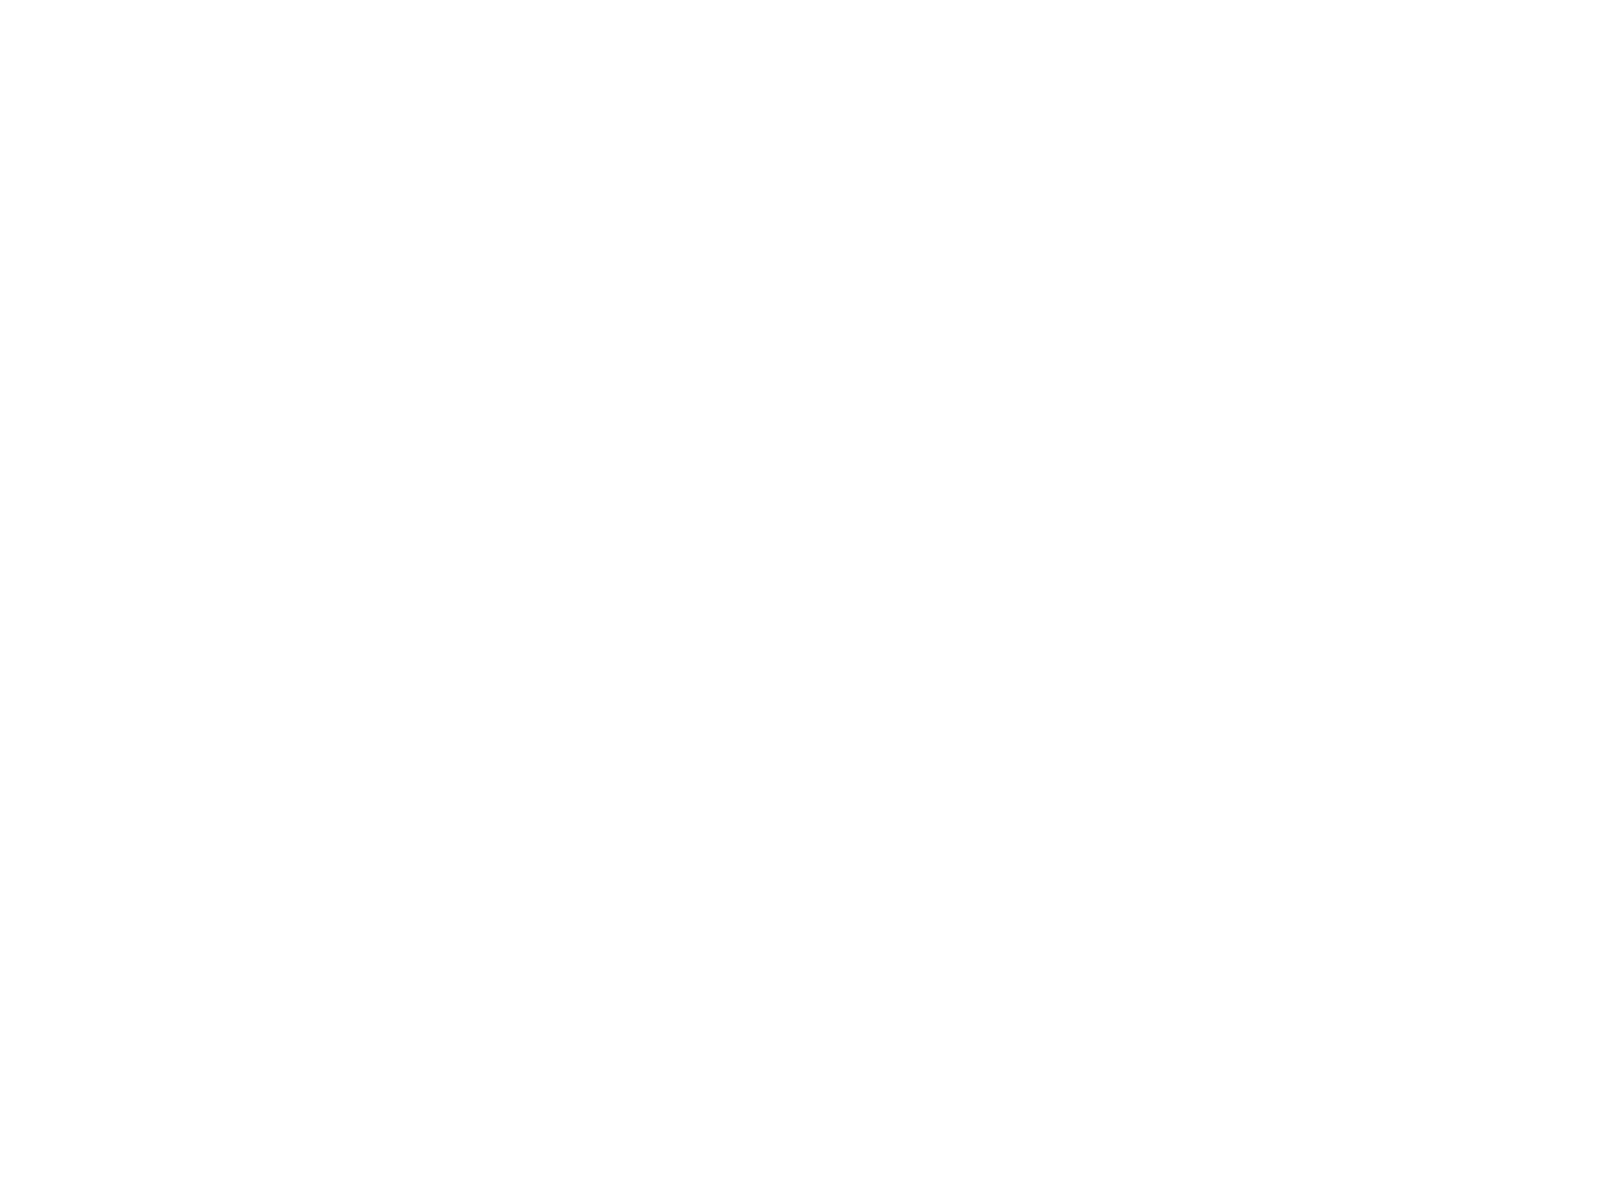

Count: 0,Before: (2047,),(2047,)
Count: 1,Before: (2047,),(2047,)
Count: 2,Before: (2047,),(2047,)
Count: 3,Before: (2046,),(2046,)
Count: 4,Before: (1246,),(1246,)


In [7]:
f,(ax1,ax2) = plt.subplots(1,2,sharey=True, figsize=[16,12],facecolor='w')
plt.text(1., 1.02, source,
         horizontalalignment='center',
         fontsize=20,
         transform = ax1.transAxes)
count = 0
start=True
ax1.set_xlim(xmin1,xmax1)
ax2.set_xlim(xmin2,xmax2)
ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax1.tick_params(labelright='off')
ax2.yaxis.tick_right()
ax1.set_ylabel(r"Flux (ergs s$^{-1}$ cm$^{-2}$ A$^{-1}$)")
label = ax1.set_xlabel(r'Lambda ($\mu$m)', fontsize = 9)
ax1.xaxis.set_label_coords(1., -0.05)
plt.ylim(ymin,ymax)
hdulist = fits.open(listoffiles)
for j in range(len(hdulist[0].data[:,0,:])):   
    if j != orderlim:
        lam = hdulist[0].data[j,0,:]
        flux = hdulist[0].data[j,1,:]
        eflux = hdulist[0].data[j,2,:]
        if j > 0:
            plotting(ax1,xmin1,xmax1,lam,flux,source+"_order"+str(j+3),listoflines,count,start)
        else:
            plotting(ax2,xmin2,xmax2,lam,flux,source+"_order"+str(j+3),listoflines,count,start)
    count +=1
            
d = .015 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1-d,1+d), (-d,+d), **kwargs)
ax1.plot((1-d,1+d),(1-d,1+d), **kwargs)

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d,+d), (1-d,1+d), **kwargs)
ax2.plot((-d,+d), (-d,+d), **kwargs)
ax2.plot((xmin2,xmin2),(-100,100),color='black')

plt.subplots_adjust(wspace=0, hspace=0)
plt.draw()
ax1.legend()
ax2.legend()
plt.savefig(source+'/'+source+'_combined.raw.pdf',dpi=1000)

# Flatten

In [8]:
def plotting2(ax,xmin,xmax,x,y,tempsource,line,count,start=False):
    colour = ['orange','black','blue','green','purple'][count]
    y = np.array(y)
    x = np.array(x)
    origx = x.copy()
    origy = y.copy()
    x = x[~np.isnan(origy)]
    y = y[~np.isnan(origy)]
     
    print("Count: {},Before: {},{}".format(count,x.shape,y.shape))
    if start == False:
        temp = []
        if count == 0:
            for i,j in enumerate(x):
                if (j < 2.) or (j > 2.4):
                    temp.append(i)
        elif count == 1:
            for i,j in enumerate(x):
                if ((1.75 < j) or (j < 1.6)):
                    temp.append(i)
        elif count == 2:
            for i,j in enumerate(x):
                if (1.33 < j) or (j < 1.17):
                    temp.append(i)
        elif count == 3:
            for i,j in enumerate(x):
                if ((j < 1.05) or ((1.11<j)) and (j<1.17)): 
                    temp.append(i)
        elif count == 4:
            for i,j in enumerate(x):
                if (j < 0.95):
                    temp.append(i)
        temp = np.array(temp)
        temp.sort()
        tempx = np.delete(x,temp)
        tempy = np.delete(y,temp)    
        expected = [1.,1.]
        params,cov = curve_fit(linear,tempx,tempy,expected)
        print('Nan params: {}'.format(params))
        if len(temp) > 0:
            # for making straight lines for nans
            y[temp[0]] = linear(x[temp[0]],*params)
            y[temp[len(temp)-1]] = linear(x[temp[len(temp)-1]],*params)
            #x = np.delete(x,temp[1:len(temp)-1])
            #y = np.delete(y,temp[1:len(temp)-1])

            x = np.delete(x,temp)
            y = np.delete(y,temp)
    expected = [1.,1.]
    params,cov = curve_fit(linear,x,y,expected)
    print('Flatten params: {}'.format(params))
    y = np.array([y[i]/linear(x[i],*params) for i in range(len(x))])
    
    print("After: {},{}".format(x.shape,y.shape))
    if x.shape[0] == 0:
        x = origx
        y = origy
    count +=1
    ax.plot(x,y,'-',color=colour,label=tempsource[-6:])
    #ax.plot(x,linear(x,*params),label='Flatten')
    for f in line:
        #print(f)
        if f == 'brg':
            naming = r'Br $\gamma$'
        elif f == 'pab':
            naming = r'Pa $\beta$'
        elif f == 'pag':
            naming = r'Pa $\gamma$'
        else:
            naming = f
        for pl,pj in enumerate(line[f]):
            if (pl < (len(line[f]))):
                if pj > 100:
                    pj = pj/10000
                val = int(int(min(range(len(x)),key=lambda i:abs(x[i]-pj))))
                if (xmin <= pj <= xmax )and (min(x) <= pj <= max(x) ):
                    if 10<=val<len(x)-11:
                        region=y[val-10:val+10] 
                    elif val > 0:
                        region=y[val:val+10]
                    elif val<len(x)-1:
                        region=y[val-10:val]
                    else:
                        region = y[val]
                    try:
                        linepos = max(region)
                    except ValueError:
                        linepos = 5*np.nanmean(x)
                    ax.text(pj, linepos*1.05, naming,
                        verticalalignment='bottom',
                        horizontalalignment='center',
                        fontsize=25, color='red',rotation='vertical')

                    ax.plot((pj,pj),(linepos,linepos*1.05),'r-')

<IPython.core.display.Javascript object>


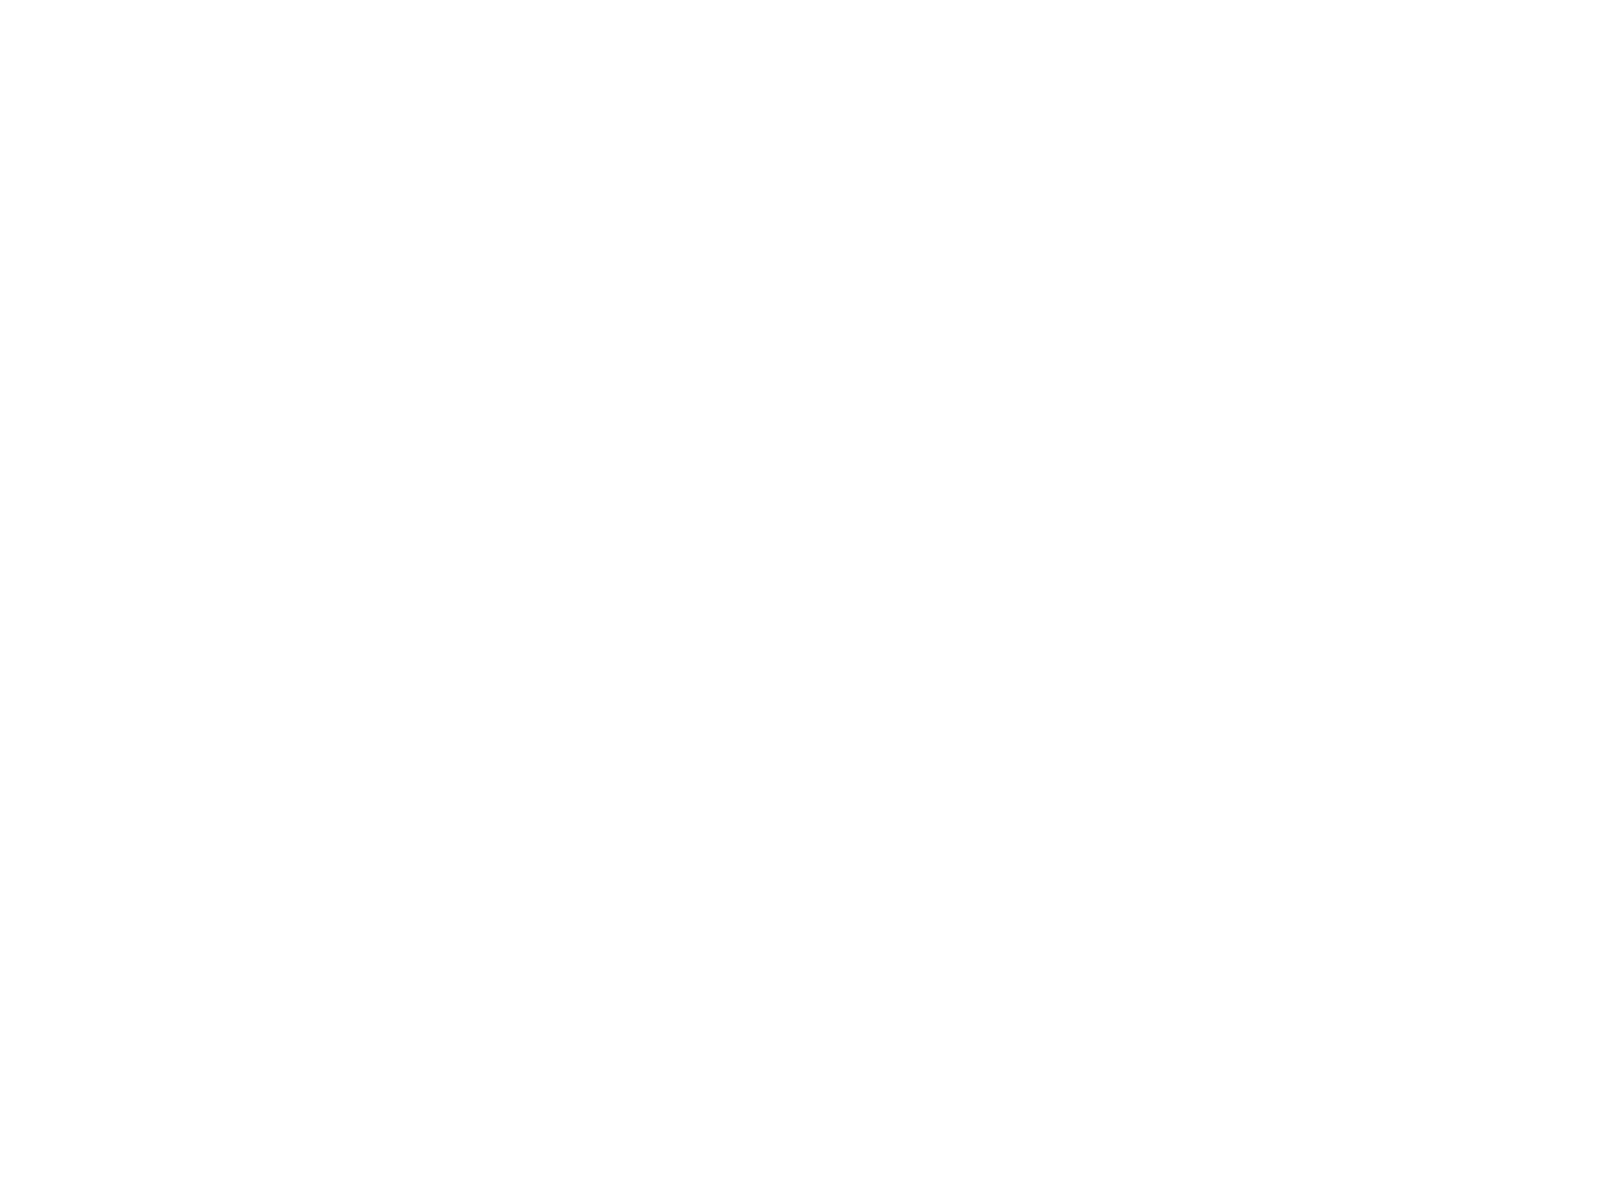

Count: 0,Before: (2047,),(2047,)
Nan params: [6.05299362e-15 8.61342992e-14]
Flatten params: [6.05299362e-15 8.61342992e-14]
After: (1390,),(1390,)
Count: 1,Before: (2047,),(2047,)
Nan params: [ 8.77463305e-14 -6.32600125e-14]
Flatten params: [ 8.77463305e-14 -6.32600125e-14]
After: (696,),(696,)
Count: 2,Before: (2047,),(2047,)
Nan params: [ 1.09130519e-13 -9.98738446e-14]
Flatten params: [ 1.09130519e-13 -9.98738446e-14]
After: (919,),(919,)
Count: 3,Before: (2046,),(2046,)
Nan params: [ 8.53880151e-14 -7.12269174e-14]
Flatten params: [ 8.53880151e-14 -7.12269174e-14]
After: (906,),(906,)
Count: 4,Before: (1246,),(1246,)
Nan params: [ 7.76844608e-14 -6.41252273e-14]
Flatten params: [ 7.76844608e-14 -6.41252273e-14]
After: (928,),(928,)


In [9]:
# make sure you add statement for naming
plt.clf()
f,(ax1,ax2) = plt.subplots(1,2,sharey=True, figsize=[16,12],facecolor='w')
plt.text(1., 1.02, source,
         horizontalalignment='center',
         fontsize=25,
         transform = ax1.transAxes)
count = 0
xmin1 = 0.95
xmax1=1.8
xmin2 = 2.
xmax2=2.4
ymin = 0.5
start=False
ymax = 2.25
ax1.set_xlim(xmin1,xmax1)
ax2.set_xlim(xmin2,xmax2)
ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax1.tick_params(labelright='off', labelsize = 25)
ax2.tick_params(labelsize = 25)
ax2.yaxis.tick_right()
ax1.set_ylabel(r"Relative Flux", fontsize = 25)
label = ax1.set_xlabel(r'Lambda ($\mu$m)', fontsize = 25)
ax1.xaxis.set_label_coords(1., -0.05)
plt.ylim(ymin,ymax)
hdulist = fits.open(listoffiles)
for j in range(len(hdulist[0].data[:,0,:])):
    if j != orderlim:   
        lam = hdulist[0].data[j,0,:]
        flux = hdulist[0].data[j,1,:]
        eflux = hdulist[0].data[j,2,:]
        if j > 0:
            plotting2(ax1,xmin1,xmax1,lam,flux,source+"_order"+str(j+3),listoflines,count,start)
        else:
            plotting2(ax2,xmin2,xmax2,lam,flux,source+"_order"+str(j+3),listoflines,count,start)
    count +=1
        
d = .015 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1-d,1+d), (-d,+d), **kwargs)
ax1.plot((1-d,1+d),(1-d,1+d), **kwargs)

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d,+d), (1-d,1+d), **kwargs)
ax2.plot((-d,+d), (-d,+d), **kwargs)
ax2.plot((xmin2,xmin2),(-100,100),color='black',linewidth=5)

plt.subplots_adjust(wspace=0, hspace=0)
plt.draw()
ax1.legend(prop={'size': 15})
ax2.legend(prop={'size': 15})
plt.savefig(source+'/'+source+'_combined.flat.pdf',dpi=1000)

# Binning

<IPython.core.display.Javascript object>


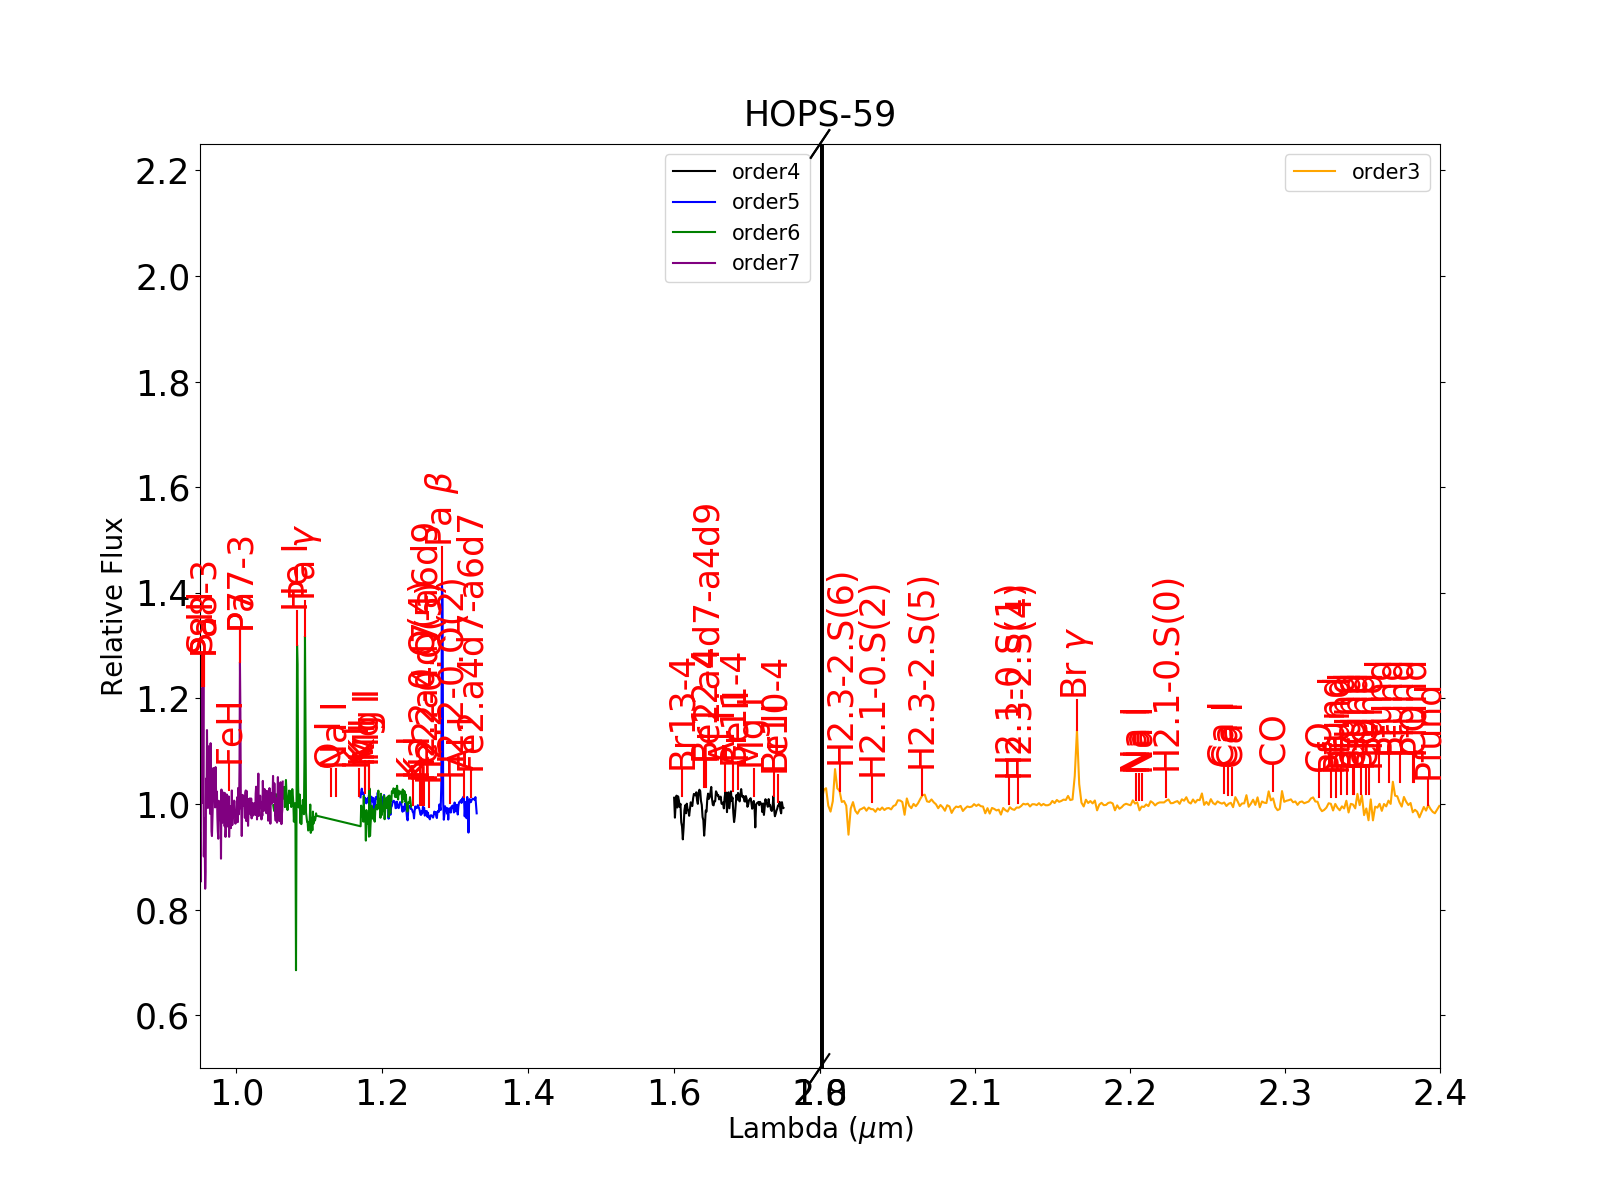

Count: 0,Before: (409,),(409,)
Nan params: [6.09428828e-15 8.60410197e-14]
Flatten params: [6.09428828e-15 8.60410197e-14]
After: (278,),(278,)
Count: 1,Before: (408,),(408,)
Nan params: [ 8.75177872e-14 -6.28756971e-14]
Flatten params: [ 8.75177872e-14 -6.28756971e-14]
After: (140,),(140,)
Count: 2,Before: (409,),(409,)
Nan params: [ 1.09120899e-13 -9.98609766e-14]
Flatten params: [ 1.09120899e-13 -9.98609766e-14]
After: (184,),(184,)
Count: 3,Before: (408,),(408,)
Nan params: [ 8.54367181e-14 -7.12821468e-14]
Flatten params: [ 8.54367181e-14 -7.12821468e-14]
After: (181,),(181,)
Count: 4,Before: (248,),(248,)
Nan params: [ 7.75406744e-14 -6.39831458e-14]
Flatten params: [ 7.75406744e-14 -6.39831458e-14]
After: (185,),(185,)


In [10]:
plt.clf()
f,(ax1,ax2) = plt.subplots(1,2,sharey=True, figsize=[16,12],facecolor='w')
plt.text(1., 1.02, source,
         horizontalalignment='center',
         fontsize=25,
         transform = ax1.transAxes)
count = 0

ax1.set_xlim(xmin1,xmax1)
ax2.set_xlim(xmin2,xmax2)
ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax1.tick_params(labelright='off', labelsize = 25)
ax2.tick_params(labelsize = 25)
ax2.yaxis.tick_right()
ax1.set_ylabel(r"Relative Flux", fontsize = 20)
label = ax1.set_xlabel(r'Lambda ($\mu$m)', fontsize = 20)
ax1.xaxis.set_label_coords(1., -0.05)
plt.ylim(ymin,ymax)
hdulist = fits.open(listoffiles)
for j in range(len(hdulist[0].data[:,0,:])):   
    if j != orderlim:
        lam = binning(hdulist[0].data[j,0,:],5)
        flux = binning(hdulist[0].data[j,1,:],5)
        if j > 0:
            plotting2(ax1,xmin1,xmax1,lam,flux,source+"_order"+str(j+3),listoflines,count)
        else:
            plotting2(ax2,xmin2,xmax2,lam,flux,source+"_order"+str(j+3),listoflines,count)
    count +=1
        
d = .015 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1-d,1+d), (-d,+d), **kwargs)
ax1.plot((1-d,1+d),(1-d,1+d), **kwargs)

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d,+d), (1-d,1+d), **kwargs)
ax2.plot((-d,+d), (-d,+d), **kwargs)
ax2.plot((xmin2,xmin2),(-100,100),color='black',linewidth=5)

plt.subplots_adjust(wspace=0, hspace=0)
plt.draw()
ax1.legend(prop={'size': 15})
ax2.legend(prop={'size': 15})
plt.savefig(source+'/'+source+'_combined.flat.binned.pdf',dpi=1000)